In [1]:
import os
import json
from typing import List, Annotated, Sequence, TypedDict

import requests
import numpy as np
from dotenv import load_dotenv
from qdrant_client import QdrantClient
from sentence_transformers import SentenceTransformer

from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, AIMessage
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langchain.docstore.document import Document
from openai import AzureOpenAI

from utility import append_to_response, get_context


load_dotenv()

# Initialize LLM model
MODEL_NAME = os.getenv("MODEL_NAME", "qwen/qwen3-32b")

# Configuration constants
COLLECTION_NAME = os.getenv("COLLECTION_NAME", "my_document_store_15")

# Initialize embedding model
embedder = SentenceTransformer(os.getenv("EMBEDDING_MODEL", "all-MiniLM-L6-v2"))

# Initialize Qdrant client
qdrant_client = QdrantClient(
    url=os.getenv("QDRANT_URL"),
    api_key=os.getenv("QDRANT_API_KEY"),
    check_compatibility=False
)

# Typed dict for agent state
class AgentState(TypedDict):
    """
    State storage for the RAG orchestrator.

    Attributes:
        messages: Conversation history (BaseMessage sequence).
    """
    messages: Annotated[Sequence[BaseMessage], add_messages]

# Hybrid search tool definition
@tool
def hybrid_search(query: str, top_k: int = 5) -> List[str]:
    """
    Perform hybrid retrieval combining vector search over Qdrant.

    Args:
        query: The user's natural language query.
        top_k: Number of top results to return.

    Returns:
        List of retrieved context strings.
    """
    print(f"🔍 Hybrid searching for: '{query}'")
    vector = embedder.encode(query).tolist()
    result = qdrant_client.query_points(
        collection_name=COLLECTION_NAME,
        query=vector,
        limit=top_k
    )
    contexts = [pt.payload.get('text', '') for pt in result.points]
    return contexts or ["No relevant context found."]


# Intent classification node
def check_query_agent(state: AgentState) -> AgentState:
    """
    Classify user intent and select an appropriate tool or return an error.

    Calls:
      - hybrid_search for document retrieval.
    """
    system = SystemMessage(
        content=(
            "You are the RAG orchestrator. Analyze the latest user message and either:"
            "\n 1) Call hybrid_search Tool for document retrieval in legal, insurance, contract, policy domains."
            "\n 2) Return 'Ambiguous query' or 'Insufficient query' as response in format \n<response here> only if the query is outside scope of above domains."
        )
    )
    latest = state['messages'][-1]
    query_msg = HumanMessage(content=f"User query: {latest.content}")
    append_to_response([{"query_agent_in": latest.content}], filename="agent_log.json")

    response = check_query_LLM.invoke([system, query_msg])

    append_to_response([{"query_agent_out": response.content}], filename="agent_log.json")
    return {"messages": [response]}


# Content checking node
def check_docs_content(state: AgentState) -> AgentState:
    """
    Decide whether to expand the query or generate an answer based on retrieved contexts.
    """
    prompt = SystemMessage(
        content=(
            "You are a RAG assistant in legal, insurance, contract, policy domains which checks whether retrieved context answer user's query correctly and precisely."
            "\n• If context is insufficient or irrelevant, return 'expand_query' as response."
            "\n• If context fully answers, return 'answer_query' as response."
            "\n• If 'expand_query' was returned twice, proceed to 'answer_query' as response to avoid loops." 
            f"\nRECENT CONVERSATION:\n{get_context(state)}"
            "Response format must be like:\n<response here>"
        )
    )
    llm = ChatGroq(model=MODEL_NAME)
    response = llm.invoke([prompt])
    append_to_response([{"check_content": response.content}], filename="agent_log.json")
    return {"messages": [response]}


# Query expansion node
def expand_query(state: AgentState) -> AgentState:
    """
    Generate an optimized search query using conversation history.
    """
    system = SystemMessage(
        content=(
            "You are a query expansion assistant in legal, insurance, contract, policy domains. Produce exactly one optimized search query."         )
    )
    human = HumanMessage(
        content=(f"RECENT CONVERSATION:\n{get_context(state)} "
                 "\nOutput query format must be like < Optimisied Query: <query here> >\n"
                 "\nDo not return anything else in the response")
    )
    llm = ChatGroq(model=MODEL_NAME, temperature=0.7)
    response = llm.invoke([system, human])

    append_to_response([{"expand_query": response.content}], filename="agent_log.json")
    return {"messages": [HumanMessage(content=f"New user query: {response.content}")]}

# Answer generation node
def answer_query(state: AgentState) -> AgentState:
    """
    Integrate tool outputs and conversation history to generate the final answer.

    Returns:
        agent message with the answer.
    """
    prompt = SystemMessage(
        content=(
            "You are a RAG assistant in legal, insurance, contract, policy domains which buildis the final response to answer user query."
            "\nUse headings, bullets, and cite sources."
            "\nDo not hallicunate and acknowledge any missing data."
            f"\nContext: {get_context(state)}"
            "\nResponse format must be like:\n<response here>"
        )
    )
    llm = ChatGroq(model=MODEL_NAME)
    response = llm.invoke([prompt])
    append_to_response([{"answer_query": response.content}], filename="agent_log.json")
    return {"messages": [response]}

# Bind the hybrid_search tool to the orchestrator
check_query_LLM = ChatGroq(model=MODEL_NAME).bind_tools([hybrid_search])

# Instantiate graph
graph = StateGraph(AgentState)

# Register and wire nodes
graph.add_node('check_query_agent', check_query_agent)

graph.add_node('hybrid_search_tool', ToolNode([hybrid_search]))

graph.add_node('check_docs_content', check_docs_content)
graph.add_node('expand_query', expand_query)
graph.add_node('answer_query',answer_query)

# router for query redirection
def route_query(state: AgentState) -> str:
    last_msg = state["messages"][-1]

    calls = getattr(last_msg, "additional_kwargs", {}).get("tool_calls", [])

    if calls:
        tool_name = calls[0].get("function", {}).get("name", "")
        if tool_name == "hybrid_search":
            return "hybrid_search_tool"

    response = (last_msg.content or "").lower()
    if "insufficient" in response or "ambiguous" in response:
        return "answer_query"

    return "hybrid_search_tool"


def route_context(state: AgentState) -> str:
    last_msg = state["messages"][-1]

    response = (last_msg.content or "").lower()
    if "answer_query" in response:
        return "answer_query"
    if "expand_query" in response:
        return "expand_query"

    return "answer_query"


# Graph wiring
graph.add_edge(START, "check_query_agent")


graph.add_conditional_edges(
    'check_query_agent',
        route_query,
        {
            'hybrid_search_tool': 'hybrid_search_tool',
            'answer_query': 'answer_query'
})
graph.add_edge("hybrid_search_tool","check_docs_content")
graph.add_conditional_edges(
    'check_docs_content',
        route_query,
        {
            'expand_query': 'expand_query',
            'answer_query': 'answer_query'
})

graph.add_edge("expand_query","hybrid_search_tool")
graph.add_edge("answer_query",END)

app = graph.compile()



c:\Users\RISHU_SINGH\Documents\Coding Dell\Indium\Bajaj-Fin RAG\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


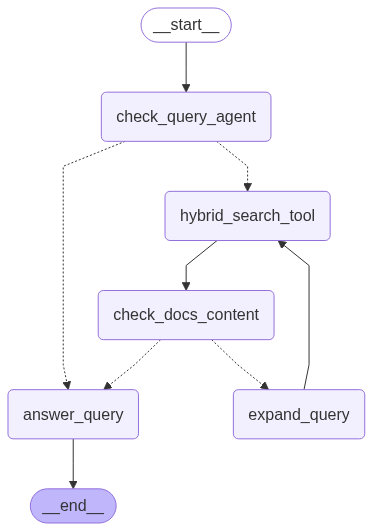

In [2]:

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))